# Определение стоимости автомобилей
**Введение:**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки:**

 - d — дата скачивания анкеты из базы;
 - VehicleType — тип автомобильного кузова;
 - RegistrationYear — год регистрации автомобиля;
 - Gearbox — тип коробки передач;
 - Power — мощность (л. с.);
 - Model — модель автомобиля;
 - Kilometer — пробег (км);
 - RegistrationMonth — месяц регистрации автомобиля;
 - FuelType — тип топлива;
 - Brand — марка автомобиля;
 - Repaired — была машина в ремонте или нет;
 - DateCreated — дата создания анкеты;
 - NumberOfPictures — количество фотографий автомобиля;
 - PostalCode — почтовый индекс владельца анкеты (пользователя);
 - LastSeen — дата последней активности пользователя;
 
**Целевой признак:**
 - Price — цена (евро)

In [2]:
!pip3 install --upgrade scikit-learn

In [3]:
!pip3 install catboost

In [4]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [5]:
#all import
# импорты из стандартной библиотеки
import warnings

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import time
import category_encoders as ce

import lightgbm as lgb
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

#настройки
warnings.filterwarnings("ignore")
# константы
RANDOM_STATE = 42

## Подготовка данных
### Загрузка данных

In [6]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('C:\\Users\\Sergo\\Documents\\autos.csv')

In [7]:
df.shape

(354369, 16)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [9]:
df.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


In [10]:
#Приведение всех столбцов к нижнему регистру.
df = df.rename(columns={'DateCrawled':'Date_Crawled', 'VehicleType':'Vehicle_Type',
                   'RegistrationYear':'Registration_Year', 'RegistrationMonth':'Registration_Month',
                   'FuelType':'Fuel_Type', 'DateCreated':'Date_Created',
                   'NumberOfPictures':'Number_Of_Pictures', 'PostalCode':'Postal_Code',
                   'LastSeen':'Last_Seen'})
df.columns = df.columns.str.lower()

In [11]:
df.head(2)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


(как вариант еще обработать столбцы с датой в нужный формат)

#### Обработка пропусков

In [12]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Думаю, пропуски в `vehicle_type` можно заполнить каким-то символом, тем самым создать новую категориальную группу. 

In [13]:
#vehicle_type

df['vehicle_type'] = df['vehicle_type'].fillna('-')
df['vehicle_type'].unique()

array(['-', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Так же чтобы не терять данный из столбца `gearbox` заполним проппуски.

In [14]:
#gearbox

df['gearbox'] = df['gearbox'].fillna('Nan')

In [15]:
#model

df['model'] = df['model'].fillna('empty')

In [16]:
#fuel_type
#Есть группа `other` - другой тип топлива, поэтому чтобы не удалять все пропуски поместим в эту группу 

df['fuel_type'] = df['fuel_type'].fillna('other')

Столбец наличие ремонта `repaired`. Можно предположить раз информации отсутствует о ремонте, значит можно предположить, что его не было.

In [17]:
#repaired

df['repaired'] = df['repaired'].fillna('no')

In [18]:
len(df)* 0.1

35436.9

In [19]:
#контрольная проверка 
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

**Вывод:**   
- Пропуски заполнены по такому принципу, чтобы пользователь, зашедший на сайт и не знающий или забыл указать, например Мощность все равно получил расчет стоимости. 
- старался заполнять пропуски разными значениями, аргументируя тем, что при шифровании категориальных фичей, а тут их достаточно много чтобы они не слились в 1 столбец. Не знаю так это может сработать или это просто надуманный страх ))

#### Удаление не информативных столбцов 
* можно удалить столбцы: `last_seen`, `postal_code`, `date_created`, `number_of_pictures`.


In [20]:
df = (df.drop(columns=['last_seen', 'postal_code', 'number_of_pictures',
                        'date_created', 'registration_month']))

In [21]:
#изменение формата даты

df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')

Сохранение от всей даты только год, т.к. выходит каждая дата будет уникальная и не позволит обучить модель. 

In [22]:
#сохранение месяца
df['date_crawled'] = df['date_crawled'].dt.year


#### Поиск анамалий в столбцах

<AxesSubplot:>

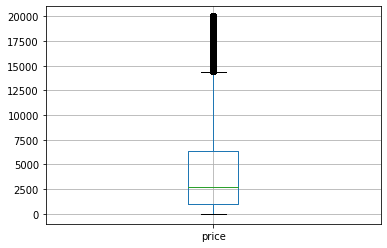

In [23]:
#price

df[['price']].boxplot()

In [24]:
df[df['price']==0].shape[0]

10772

<AxesSubplot:>

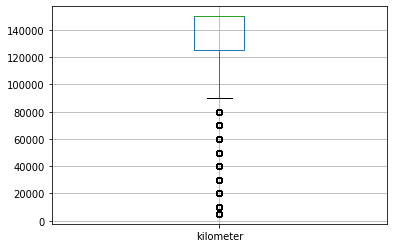

In [26]:
#kilometer

df[['kilometer']].boxplot()

In [27]:
df = df[df['kilometer']>15_000]

Машины уж совсем новые без пробега удалим всё-таки сайт для продажи подержанных автомобилей.

среднее: 110.74446431146359 
медиана 105.0


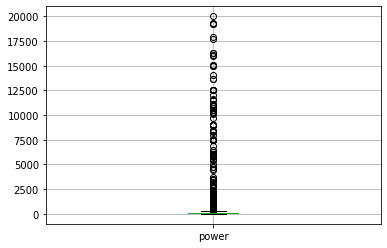

In [28]:
#'power'

df[['power']].boxplot() 
print ('среднее:',df['power'].mean(), '\nмедиана',df['power'].median())

In [29]:
#Присутствуют слишком мощные экземпляры 
#их можно считать выбросами в нашей 
#выборке объявлений, поэтому удаляем их.
df[df['power']>400].shape[0]

686

In [30]:
df = df[(df['power']<400) & (df['power']>10)]

In [31]:
#заменим yes, no на численные значения
df['repaired'] = df['repaired'].replace({'yes': 1, 'no': 0})

Построение сводный таблиц:

In [32]:
#vehicle_type

df.groupby('vehicle_type').count()[['price']]

,price
vehicle_type,
-,22091
bus,26252
convertible,18759
coupe,14750
other,2474
sedan,83660
small,70046
suv,10873
wagon,59858


In [33]:
#registration_year

(df.groupby('registration_year').count()[['price']]
 .sort_values(by='price', ascending=False)
 .reset_index(drop=False))
#.head(50)

,registration_year,price
0,1999,19924
1,2000,19113
2,2005,19000
3,2006,18553
4,2001,18070
...,...,...
81,1941,1
82,1936,1
83,1947,1
84,1949,1


In [36]:
#дата скачивания анкеты
df['date_crawled'].max()

2016

<AxesSubplot:>

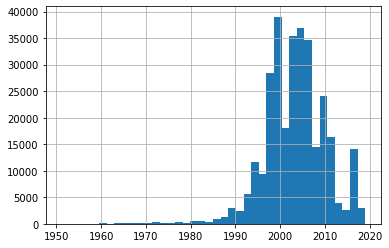

In [37]:
df[(df['registration_year']>1950) & 
   (df['registration_year']<2022)]['registration_year'].hist(bins = 40)

In [38]:
df = df[df['registration_year']<2016] 

In [39]:
#gearbox

df.groupby('gearbox').count()[['date_crawled']]

,date_crawled
gearbox,
Nan,5020
auto,58150
manual,228591


In [40]:
#model

df.groupby('model').count()[['date_crawled']].reset_index(drop=False)#.head(10)#.sort_values(by='date_crawled', ascending=True).

,model,date_crawled
0,100,374
1,145,35
2,147,482
3,156,546
4,159,195
...,...,...
245,yaris,885
246,yeti,168
247,ypsilon,167
248,z_reihe,686


In [41]:
#fuel_type

df.groupby('fuel_type').count()[['date_crawled']]

,date_crawled
fuel_type,
cng,475
electric,47
gasoline,87320
hybrid,194
lpg,4692
other,13585
petrol,185448


In [42]:
#brand

df.groupby('brand').count()[['date_crawled']].sort_values(by='date_crawled', ascending=False)

,date_crawled
brand,
volkswagen,62930
bmw,32150
opel,31903
mercedes_benz,27090
audi,25458
ford,20291
renault,13664
peugeot,9239
fiat,7471


In [43]:
#repaired

df.groupby('repaired')[['model']].count()#.plot(kind='bar', grid = True)

,model
repaired,
0,262813
1,28948


In [44]:
#registration_month

#df.groupby('registration_month')[['model']].count()

Странно месяц публикации 0. Долго думал, что с этим месяцем сделать - решил удалить. Конечно, много данных потеряю, но это самое очевидное решение. 

In [45]:
#df = df[df['registration_month']>0]

**Проверка на наличие дубликатов.**

In [46]:
df.duplicated().sum()

45596

Есть вероятность повторение дубликатов, но думаю это просто повторно опубликованные объявления с разных профилей.

In [47]:
df = df.drop_duplicates()

**Вывод** 

Данные полностью рассмотрены и обработаны:
* старался по максимуму сохранить и восстановить пропуски, если в дальнейшем обучении они будут мешать их можно будет просто удалить. 
* преобразовал дату из численного формата в форматы даты и времени.
* обработал выбросы
* исключил некоторые столбцы из датасета, которые были не информативны для моего исследования
* проверил наличие дубликатов
* Построил сводные таблицы и гистограммы чтобы было понимание о внутренней структуре фитчей.


## Обучение моделей
Разделение таблицы на признаки и целевой показатель, далее необходимо разделить датасет на тренировочную и тестовую выборку 

In [48]:
x = df.drop('price', axis=1)
y = df['price']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=.4, random_state=RANDOM_STATE
    )

x_valid, x_test, y_valid, y_test = train_test_split(
    x_test, y_test, test_size=.5, random_state=RANDOM_STATE
    )

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((147699, 10), (147699,), (49233, 10), (49233,), (49233, 10), (49233,))

**Cтандартизацию фитчей.**

Удалили из списка Бренд и Модель чтобы отдель кодировать

In [49]:
# Light GBM 
# (требуется избавится от формата object, хотя пишут в мануалах,
# что автоматически сам кодирует c этим не разобрался и пришлось кодировать)

light_features_gbm = x_train.select_dtypes(include='object').columns.to_list()

light_features_lr = light_features_gbm.copy()#параметры для лин. рег.

light_features_gbm.remove('model')
light_features_gbm.remove('brand')
print(light_features_lr)
print(light_features_gbm)#категориальные

num_features = x_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('repaired')#удаляем т.к. уже за кодирован 
print(num_features)#числительные

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']
['vehicle_type', 'gearbox', 'fuel_type']
['date_crawled', 'registration_year', 'power', 'kilometer']


In [50]:
#проверка кол-ва совпадания уникальных значений свои какие-то 
#эксперементы и опасения что не все переменный могут войти в учебный датасет и 
#ничего не обучится нормально.

print('весь датасет   model:', len(df[['model']].value_counts()), 'brand:', len(df[['brand']].value_counts()))
print('')
print('тренировочная выборка   model:', len(x_train[['model']].value_counts()), 'brand:', len(x_train[['brand']].value_counts()))
print('валидационная выборка   model:', len(x_valid[['model']].value_counts()), 'brand:', len(x_valid[['brand']].value_counts()))
print('тестовая выборка   model:', len(x_test[['model']].value_counts()), 'brand:', len(x_test[['brand']].value_counts()))

весь датасет   model: 250 brand: 40

тренировочная выборка   model: 249 brand: 40
валидационная выборка   model: 245 brand: 40
тестовая выборка   model: 247 brand: 40


In [51]:
models_train = set(x_train['model'].unique())
models_test = set(x_valid['model'].unique())
num_models_train = len(models_train)
num_models_test = len(models_test)
print(f'''
Количество уникальных значений признка "model" 
в обеих выборках одинаковое: {num_models_train == num_models_test}
''')
print(f'''
Уникальные значения признка "model" 
в обеих выборках одинаковые: {models_train == models_test}
''')
print(f'''
Только в тренировочной выборке есть значения: {models_train - models_test}
''')
print(f'''
Только в тестовой выборке есть значения: {models_test - models_train}
''')


Количество уникальных значений признка "model" 
в обеих выборках одинаковое: False


Уникальные значения признка "model" 
в обеих выборках одинаковые: False


Только в тренировочной выборке есть значения: {'range_rover_evoque', 'samara', 'rangerover', 'i3', 'kalina'}


Только в тестовой выборке есть значения: {'serie_2'}



In [52]:
#кодируем модель и бренд, и сохраняем
encoder = ce.MEstimateEncoder(cols=['model','brand'])

x_train_encoded = encoder.fit_transform(x_train, y_train)

x_valid_encoded = encoder.transform(x_valid, y_valid)

x_test_encoded = encoder.transform(x_test, y_test)

In [53]:
x_test_encoded.head()

,date_crawled,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
68261,2016,wagon,2007,manual,160,7036.884444,150000,petrol,6194.327391,0
286757,2016,convertible,2007,manual,170,10085.424757,30000,petrol,9242.413793,0
234575,2016,wagon,2005,manual,90,3655.027327,150000,gasoline,3520.070063,0
34403,2016,sedan,1999,manual,150,5514.863439,150000,petrol,6678.826400,0
26510,2016,sedan,1995,manual,102,5514.863439,150000,petrol,6678.826400,0


In [54]:
x_train_gbm = x_train_encoded.copy()
x_valid_gbm = x_valid_encoded.copy()
x_test_gbm = x_test_encoded.copy()

encoder_gbm = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

#обучение на котигариальных признаках
encoder_gbm.fit(x_train_gbm[light_features_gbm])
x_train_gbm[encoder_gbm.get_feature_names_out()] = encoder_gbm.transform(x_train_gbm[light_features_gbm])

#удаляем исходные фичи
x_train_gbm = x_train_gbm.drop(light_features_gbm, axis=1)



#создание скеллер
scal = StandardScaler()
##обучение на численных прихнакх
x_train_gbm[num_features] = scal.fit_transform(x_train_gbm[num_features])

x_train_gbm.head()

,date_crawled,registration_year,power,model,kilometer,brand,repaired,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,...,vehicle_type_suv,vehicle_type_wagon,gearbox_auto,gearbox_manual,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol
311376,0.0,-0.393260,3.486902,13923.158358,0.610498,6287.800351,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
344277,0.0,0.703628,2.255604,5514.863439,0.610498,6678.826400,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
124527,0.0,0.546930,0.531787,5948.550896,0.610498,6287.800351,0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
317184,0.0,0.076835,1.346338,3584.438036,0.610498,6678.826400,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
33164,0.0,-0.863355,-0.131220,1782.791577,0.610498,3133.767929,0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [55]:
#обученным экодером => кодируем валидационную выборку и удаляем фитчи
x_valid_gbm[encoder_gbm.get_feature_names_out()] = encoder_gbm.transform(x_valid_gbm[light_features_gbm])
x_valid_gbm = x_valid_gbm.drop(light_features_gbm, axis=1)

#обученным скеллером => масштабируем валидационную выборку 
x_valid_gbm[num_features] = scal.transform(x_valid_gbm[num_features])

x_valid_gbm.head()

,date_crawled,registration_year,power,model,kilometer,brand,repaired,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,...,vehicle_type_suv,vehicle_type_wagon,gearbox_auto,gearbox_manual,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol
321569,0.0,-0.079864,1.346338,6574.613714,0.610498,6678.826400,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
138567,0.0,1.330421,1.194794,3434.289547,0.610498,3916.029088,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
145369,0.0,-0.079864,-1.210973,1691.501310,0.610498,2635.343295,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
350733,0.0,0.860326,-0.794226,2315.926003,0.610498,3133.767929,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
104691,0.0,0.546930,-0.320650,4791.525557,0.610498,5014.861763,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [56]:
#обученный экодер => кодирует тестовую выборку и удаляем фитчи
x_test_gbm[encoder_gbm.get_feature_names_out()] = encoder_gbm.transform(x_test_gbm[light_features_gbm])
x_test_gbm = x_test_gbm.drop(light_features_gbm, axis=1)

#обученный скеллер => маштабирует тестовую выборку 
x_test_gbm[num_features] = scal.transform(x_test_gbm[num_features])

x_test_gbm.head()

,date_crawled,registration_year,power,model,kilometer,brand,repaired,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,...,vehicle_type_suv,vehicle_type_wagon,gearbox_auto,gearbox_manual,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol
68261,0.0,0.703628,0.721217,7036.884444,0.610498,6194.327391,0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
286757,0.0,0.703628,0.910648,10085.424757,-2.828287,9242.413793,0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
234575,0.0,0.390231,-0.604796,3655.027327,0.610498,3520.070063,0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
34403,0.0,-0.549959,0.531787,5514.863439,0.610498,6678.826400,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
26510,0.0,-1.176752,-0.377479,5514.863439,0.610498,6678.826400,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [57]:
#проверка совподения кол-ва признаков
#(x_train_gbm.columns != x_test_gbm.columns).sum(), 
#(x_train_gbm.columns != x_valid_gbm.columns).sum()


### 1 Обучение  LightGBM

In [58]:
#старт времени
start_time = time.time()


#cоздание модели LightGBM
model = lgb.LGBMRegressor(random_state=RANDOM_STATE)

#перевод в понятный формат для модели - удалить
trein_df_lgb = lgb.Dataset(x_train, label=y_train)

#определение параметров для перебора
param = {
    'objective': ['regression'], #тип модели
    'metric': ['rmse'], #метрика оценки качества
    #'num_leaves': [100],  # кол-во листьев
    'learning_rate': [0.2], #скорость обучения
    'max_depth': [10]
    }

#подбор гиппер параметров
grid_search_lgb = (GridSearchCV(estimator=model, param_grid=param, 
                                scoring='neg_root_mean_squared_error', cv=2,
                                n_jobs=-1)) #neg_ означает что метрика расчитывается "-"

# Обучение модели с подбором гиперпараметров
grid_search_lgb.fit(x_train_gbm, y_train)

# Лучшие параметры модели
best_params = grid_search_lgb.best_params_
print(f'Лучшие параметры: {best_params}')

# Прогнозирование на валидационной выборке с использованием модели с лучшими параметрами
y_pred = grid_search_lgb.predict(x_valid_gbm)

# Расчет RMSE
rmse_light_gbm = mean_squared_error(y_valid, y_pred, squared=False)
print(f'RMSE LightGBM: {rmse_light_gbm}')


#время финиш
end_time = time.time()
execution_time_lgbmr = end_time - start_time

Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 10, 'metric': 'rmse', 'objective': 'regression'}
RMSE LightGBM: 1776.1121962853535


### 2 Обучение LinearRegression

In [59]:
#старт времени
start_time = time.time()


model_lr = LinearRegression().fit(x_train_gbm, y_train)
lr_pred = model_lr.predict(x_train_gbm)
rmse_lr = mean_squared_error(y_train, lr_pred, squared=False)
print(f'RMSE LinearRegression: {rmse_lr}')


#время финиш
end_time = time.time()
execution_time_lr = end_time - start_time

RMSE LinearRegression: 2735.02152740675


In [60]:
#старт времени
#start_time = time.time()


#подбор гиппер параметров
#modell_lr = LinearRegression()

#parameters = {
#    'fit_intercept':[True,False], 
#    'normalize':[True,False], 
#    'copy_X':[True, False]
#    }
    
#grid = (GridSearchCV(estimator = modell_lr, param_grid=parameters, cv=3,
#                     scoring='neg_root_mean_squared_error'))
                     
#grid.fit(x_train_gbm, y_train)

# Лучшие параметры модели
#best_params_lr = grid.best_params_
#print(f'Лучшие параметры: {best_params_lr}')

# Прогнозирование на валидационной выборке с использованием модели с лучшими параметрами
#y_pred = grid.predict(x_valid_gbm)

# Расчет RMSE
#rmse_lr = mean_squared_error(y_valid, y_pred, squared=False)
#print(f'RMSE LinearRegression: {rmse_lr}')


#время финиш
#end_time = time.time()
#execution_time_lr = end_time - start_time

### 3 Обучение CatBoostRegressor

In [61]:
#старт времени
start_time = time.time()


model_cat = CatBoostRegressor(random_state=RANDOM_STATE)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0,4],#
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 5],
    'iterations': [100]
}

#oпределение категориальных признаков
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

grid_cat = GridSearchCV(estimator=model_cat, param_grid=param_grid, verbose=3, 
                        scoring='neg_root_mean_squared_error', cv=3)

grid_cat.fit(x_train, y_train, cat_features=cat_features)

#лучшие параметры
best_cat = grid_cat.best_params_
print(best_cat)

#предсказание
у_pred = grid_cat.predict(x_valid)

# Расчет RMSE
rmse_cat = mean_squared_error(y_valid, у_pred, squared=False)
print(f'RMSE CatBoostRegressor: {rmse_cat}')


#время финиш
end_time = time.time()
execution_time_cat = end_time - start_time
# %%time время обучения

Fitting 3 folds for each of 30 candidates, totalling 90 fits
0:	learn: 4623.5835376	total: 80ms	remaining: 7.92s
1:	learn: 4595.7379846	total: 115ms	remaining: 5.63s
2:	learn: 4567.5298715	total: 150ms	remaining: 4.85s
3:	learn: 4539.2392188	total: 174ms	remaining: 4.17s
4:	learn: 4510.8569423	total: 197ms	remaining: 3.74s
5:	learn: 4483.1723862	total: 231ms	remaining: 3.63s
6:	learn: 4456.6510770	total: 264ms	remaining: 3.5s
7:	learn: 4429.8496149	total: 287ms	remaining: 3.3s
8:	learn: 4402.9949651	total: 315ms	remaining: 3.18s
9:	learn: 4377.2805430	total: 345ms	remaining: 3.1s
10:	learn: 4351.1341485	total: 368ms	remaining: 2.97s
11:	learn: 4325.3299318	total: 391ms	remaining: 2.87s
12:	learn: 4300.7001275	total: 415ms	remaining: 2.78s
13:	learn: 4275.9819201	total: 439ms	remaining: 2.7s
14:	learn: 4251.3184452	total: 465ms	remaining: 2.64s
15:	learn: 4226.7506530	total: 492ms	remaining: 2.58s
16:	learn: 4202.7758457	total: 518ms	remaining: 2.53s
17:	learn: 4179.5422053	total: 542ms

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11436.0378933	total: 76.3ms	remaining: 7.55s
1:	learn: 33334.8410910	total: 105ms	remaining: 5.17s
2:	learn: 99576.1135325	total: 128ms	remaining: 4.15s
3:	learn: 298475.7011007	total: 163ms	remaining: 3.91s
4:	learn: 895078.6980349	total: 191ms	remaining: 3.62s
5:	learn: 2684328.6590316	total: 218ms	remaining: 3.41s
6:	learn: 8050313.1687567	total: 262ms	remaining: 3.48s
7:	learn: 24142948.2155822	total: 285ms	remaining: 3.28s
8:	learn: 72404911.6237354	total: 308ms	remaining: 3.11s
9:	learn: 217143044.5629848	total: 334ms	remaining: 3s
10:	learn: 651214383.6605976	total: 369ms	remaining: 2.98s
11:	learn: 1952999859.4292924	total: 393ms	remaining: 2.88s
12:	learn: 5857072570.7826338	total: 416ms	remaining: 2.79s
13:	learn: 17565445267.3582802	total: 444ms	remaining: 2.73s
14:	learn: 52679044128.5604706	total: 471ms	remaining: 2.67s
15:	learn: 157985334136.9111328	total: 494ms	remaining: 2.59s
16:	learn: 473800837344.0216675	total: 517ms	remaining: 2.52s
17:	learn: 1420937703

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11468.2983013	total: 42.1ms	remaining: 4.17s
1:	learn: 33359.5898974	total: 77.5ms	remaining: 3.79s
2:	learn: 99550.9447916	total: 105ms	remaining: 3.4s
3:	learn: 298388.9198310	total: 128ms	remaining: 3.07s
4:	learn: 894816.7569325	total: 151ms	remaining: 2.88s
5:	learn: 2683548.7801169	total: 185ms	remaining: 2.9s
6:	learn: 8047994.8955649	total: 215ms	remaining: 2.86s
7:	learn: 24136058.5152704	total: 239ms	remaining: 2.75s
8:	learn: 72384437.7796120	total: 266ms	remaining: 2.69s
9:	learn: 217082207.4405908	total: 296ms	remaining: 2.66s
10:	learn: 651033621.1046396	total: 319ms	remaining: 2.58s
11:	learn: 1952462804.8714209	total: 342ms	remaining: 2.51s
12:	learn: 5855477066.5803938	total: 370ms	remaining: 2.48s
13:	learn: 17560705614.0328865	total: 396ms	remaining: 2.43s
14:	learn: 52664965390.3719025	total: 418ms	remaining: 2.37s
15:	learn: 157943517523.6116638	total: 441ms	remaining: 2.31s
16:	learn: 473676643127.6654053	total: 467ms	remaining: 2.28s
17:	learn: 14205688

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11448.7195621	total: 39.9ms	remaining: 3.94s
1:	learn: 33302.2692576	total: 69.4ms	remaining: 3.4s
2:	learn: 99394.8467285	total: 92.5ms	remaining: 2.99s
3:	learn: 297927.0807182	total: 121ms	remaining: 2.9s
4:	learn: 893436.8093807	total: 148ms	remaining: 2.81s
5:	learn: 2679421.0546128	total: 171ms	remaining: 2.68s
6:	learn: 8035646.5725188	total: 200ms	remaining: 2.65s
7:	learn: 24099117.7060453	total: 233ms	remaining: 2.68s
8:	learn: 72273927.9906927	total: 257ms	remaining: 2.6s
9:	learn: 216751616.9070181	total: 280ms	remaining: 2.52s
10:	learn: 650044668.8592951	total: 305ms	remaining: 2.46s
11:	learn: 1949504414.6807418	total: 338ms	remaining: 2.48s
12:	learn: 5846627320.6849222	total: 360ms	remaining: 2.41s
13:	learn: 17534232724.2659035	total: 383ms	remaining: 2.35s
14:	learn: 52585775982.8221817	total: 408ms	remaining: 2.31s
15:	learn: 157706637729.1589966	total: 438ms	remaining: 2.3s
16:	learn: 472968070924.9632568	total: 460ms	remaining: 2.25s
17:	learn: 141844936

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11421.7694962	total: 30.5ms	remaining: 3.02s
1:	learn: 33247.3345881	total: 71ms	remaining: 3.48s
2:	learn: 99183.0989905	total: 95ms	remaining: 3.07s
3:	learn: 296910.1123297	total: 119ms	remaining: 2.87s
4:	learn: 889233.0804056	total: 158ms	remaining: 3s
5:	learn: 2663375.8124680	total: 182ms	remaining: 2.84s
6:	learn: 7977296.1198986	total: 211ms	remaining: 2.81s
7:	learn: 23893685.7104918	total: 237ms	remaining: 2.72s
8:	learn: 71567271.1691445	total: 266ms	remaining: 2.69s
9:	learn: 214362874.7302550	total: 289ms	remaining: 2.6s
10:	learn: 642078962.3708409	total: 313ms	remaining: 2.53s
11:	learn: 1923229073.3270097	total: 343ms	remaining: 2.51s
12:	learn: 5760726435.4345083	total: 369ms	remaining: 2.47s
13:	learn: 17255482389.2391014	total: 393ms	remaining: 2.41s
14:	learn: 51686905241.7553329	total: 416ms	remaining: 2.36s
15:	learn: 154823714314.6383057	total: 452ms	remaining: 2.37s
16:	learn: 463764946508.3674316	total: 475ms	remaining: 2.32s
17:	learn: 1389190480706

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11454.0152470	total: 37.9ms	remaining: 3.75s
1:	learn: 33272.3046344	total: 67.4ms	remaining: 3.3s
2:	learn: 99159.8170654	total: 90.5ms	remaining: 2.93s
3:	learn: 296832.0691309	total: 125ms	remaining: 3.01s
4:	learn: 889006.7614759	total: 149ms	remaining: 2.82s
5:	learn: 2662730.7163856	total: 172ms	remaining: 2.69s
6:	learn: 7975464.7314348	total: 205ms	remaining: 2.73s
7:	learn: 23888500.5906964	total: 231ms	remaining: 2.66s
8:	learn: 71552631.9668278	total: 254ms	remaining: 2.57s
9:	learn: 214321672.2005098	total: 277ms	remaining: 2.5s
10:	learn: 641963401.3008155	total: 307ms	remaining: 2.48s
11:	learn: 1922906238.7831385	total: 335ms	remaining: 2.45s
12:	learn: 5759828620.8254032	total: 358ms	remaining: 2.39s
13:	learn: 17252998487.6982155	total: 380ms	remaining: 2.34s
14:	learn: 51680074724.9923401	total: 415ms	remaining: 2.35s
15:	learn: 154805064407.8538513	total: 439ms	remaining: 2.31s
16:	learn: 463714457122.1813965	total: 462ms	remaining: 2.26s
17:	learn: 1389055

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11434.6340621	total: 29.5ms	remaining: 2.92s
1:	learn: 33216.1380325	total: 60ms	remaining: 2.94s
2:	learn: 99008.9521511	total: 94.4ms	remaining: 3.05s
3:	learn: 296391.1571712	total: 118ms	remaining: 2.82s
4:	learn: 887705.2930266	total: 141ms	remaining: 2.68s
5:	learn: 2658885.7029906	total: 167ms	remaining: 2.62s
6:	learn: 7964106.9266025	total: 201ms	remaining: 2.67s
7:	learn: 23854960.0016399	total: 225ms	remaining: 2.59s
8:	learn: 71453612.8692193	total: 249ms	remaining: 2.52s
9:	learn: 214029434.3737845	total: 285ms	remaining: 2.57s
10:	learn: 641101176.1384022	total: 309ms	remaining: 2.5s
11:	learn: 1920363104.6570265	total: 338ms	remaining: 2.48s
12:	learn: 5752330032.7913265	total: 367ms	remaining: 2.46s
13:	learn: 17230895624.0624123	total: 396ms	remaining: 2.43s
14:	learn: 51614945878.3095093	total: 420ms	remaining: 2.38s
15:	learn: 154613219271.3676453	total: 446ms	remaining: 2.34s
16:	learn: 463149549653.9685669	total: 480ms	remaining: 2.34s
17:	learn: 13873923

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11764.8635277	total: 37.2ms	remaining: 3.68s
1:	learn: 34460.1131347	total: 76.1ms	remaining: 3.73s
2:	learn: 103051.7141456	total: 114ms	remaining: 3.67s
3:	learn: 308898.1686348	total: 157ms	remaining: 3.76s
4:	learn: 926301.4440927	total: 189ms	remaining: 3.6s
5:	learn: 2777852.3784527	total: 222ms	remaining: 3.47s
6:	learn: 8330447.2794591	total: 263ms	remaining: 3.5s
7:	learn: 24982038.3173316	total: 296ms	remaining: 3.4s
8:	learn: 74918245.1077541	total: 334ms	remaining: 3.38s
9:	learn: 224671235.2187769	total: 370ms	remaining: 3.33s
10:	learn: 673763528.6350982	total: 402ms	remaining: 3.25s
11:	learn: 2020541020.8160117	total: 443ms	remaining: 3.25s
12:	learn: 6059377257.1095772	total: 475ms	remaining: 3.18s
13:	learn: 18171403002.4195786	total: 506ms	remaining: 3.11s
14:	learn: 54494048574.4185028	total: 551ms	remaining: 3.12s
15:	learn: 163421741844.8469849	total: 584ms	remaining: 3.07s
16:	learn: 490084245556.8225708	total: 615ms	remaining: 3s
17:	learn: 14697104899

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11812.9517055	total: 37.5ms	remaining: 3.71s
1:	learn: 34516.8726558	total: 76ms	remaining: 3.72s
2:	learn: 102023.5129096	total: 114ms	remaining: 3.69s
3:	learn: 305431.0168341	total: 145ms	remaining: 3.49s
4:	learn: 915762.2251279	total: 178ms	remaining: 3.39s
5:	learn: 2746197.7313758	total: 212ms	remaining: 3.33s
6:	learn: 8235498.1649960	total: 244ms	remaining: 3.25s
7:	learn: 24697278.2885660	total: 291ms	remaining: 3.34s
8:	learn: 74064243.8892772	total: 323ms	remaining: 3.26s
9:	learn: 222110081.6841132	total: 355ms	remaining: 3.19s
10:	learn: 666082646.3806778	total: 386ms	remaining: 3.13s
11:	learn: 1997506188.4497311	total: 419ms	remaining: 3.07s
12:	learn: 5990296438.4409475	total: 451ms	remaining: 3.02s
13:	learn: 17964232282.7128181	total: 484ms	remaining: 2.98s
14:	learn: 53872753714.3580246	total: 515ms	remaining: 2.92s
15:	learn: 161558515394.3487549	total: 546ms	remaining: 2.87s
16:	learn: 484496559178.5876465	total: 579ms	remaining: 2.83s
17:	learn: 1452953

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11797.0734305	total: 40.1ms	remaining: 3.97s
1:	learn: 34525.1726245	total: 78.7ms	remaining: 3.85s
2:	learn: 102845.1733146	total: 126ms	remaining: 4.06s
3:	learn: 308166.4906449	total: 159ms	remaining: 3.82s
4:	learn: 924006.2294539	total: 197ms	remaining: 3.75s
5:	learn: 2770943.1152142	total: 230ms	remaining: 3.61s
6:	learn: 8309741.2416243	total: 262ms	remaining: 3.48s
7:	learn: 24920017.1030697	total: 306ms	remaining: 3.52s
8:	learn: 74732484.9815653	total: 338ms	remaining: 3.42s
9:	learn: 224114876.4110095	total: 371ms	remaining: 3.34s
10:	learn: 672097240.6751776	total: 417ms	remaining: 3.38s
11:	learn: 2015550589.9861355	total: 455ms	remaining: 3.33s
12:	learn: 6044431464.0947561	total: 502ms	remaining: 3.36s
13:	learn: 18126642717.5440712	total: 535ms	remaining: 3.29s
14:	learn: 54360000774.8170166	total: 568ms	remaining: 3.22s
15:	learn: 163020302885.0736694	total: 619ms	remaining: 3.25s
16:	learn: 488882057686.4219360	total: 664ms	remaining: 3.24s
17:	learn: 14661

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11748.2009035	total: 38.7ms	remaining: 3.83s
1:	learn: 34358.2338657	total: 76.7ms	remaining: 3.76s
2:	learn: 102593.8322100	total: 122ms	remaining: 3.95s
3:	learn: 307073.2870308	total: 154ms	remaining: 3.7s
4:	learn: 919484.0012356	total: 194ms	remaining: 3.68s
5:	learn: 2753402.5406563	total: 227ms	remaining: 3.56s
6:	learn: 8245195.7060734	total: 259ms	remaining: 3.45s
7:	learn: 24690844.7461312	total: 303ms	remaining: 3.48s
8:	learn: 73939139.0181087	total: 334ms	remaining: 3.38s
9:	learn: 221419682.9667647	total: 367ms	remaining: 3.3s
10:	learn: 663073103.8636432	total: 410ms	remaining: 3.32s
11:	learn: 1985682971.0494351	total: 442ms	remaining: 3.24s
12:	learn: 5946503560.0805950	total: 480ms	remaining: 3.21s
13:	learn: 17808063219.3248978	total: 517ms	remaining: 3.18s
14:	learn: 53330405957.2360535	total: 549ms	remaining: 3.11s
15:	learn: 159711521799.1080627	total: 590ms	remaining: 3.1s
16:	learn: 478300380171.1068726	total: 623ms	remaining: 3.04s
17:	learn: 14324131

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11796.3372054	total: 56ms	remaining: 5.54s
1:	learn: 34415.4534733	total: 98.5ms	remaining: 4.83s
2:	learn: 101570.7636434	total: 141ms	remaining: 4.56s
3:	learn: 303626.5636610	total: 177ms	remaining: 4.24s
4:	learn: 909021.4024661	total: 207ms	remaining: 3.94s
5:	learn: 2722026.4283501	total: 249ms	remaining: 3.9s
6:	learn: 8151235.4783400	total: 283ms	remaining: 3.75s
7:	learn: 24409531.6782822	total: 314ms	remaining: 3.61s
8:	learn: 73096978.6244599	total: 360ms	remaining: 3.64s
9:	learn: 218898722.9981963	total: 392ms	remaining: 3.53s
10:	learn: 655527312.6808593	total: 423ms	remaining: 3.42s
11:	learn: 1963098385.5948699	total: 462ms	remaining: 3.39s
12:	learn: 5878912588.3333006	total: 494ms	remaining: 3.31s
13:	learn: 17605791496.4648628	total: 531ms	remaining: 3.26s
14:	learn: 52725131645.0084152	total: 571ms	remaining: 3.23s
15:	learn: 157900429647.9083557	total: 601ms	remaining: 3.16s
16:	learn: 472881610117.4702148	total: 643ms	remaining: 3.14s
17:	learn: 14162012

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11780.5708324	total: 48.2ms	remaining: 4.77s
1:	learn: 34424.3749124	total: 86.4ms	remaining: 4.23s
2:	learn: 102394.0021704	total: 134ms	remaining: 4.35s
3:	learn: 306367.4449641	total: 167ms	remaining: 4s
4:	learn: 917282.8547162	total: 199ms	remaining: 3.79s
5:	learn: 2746827.0088742	total: 244ms	remaining: 3.82s
6:	learn: 8225651.2251361	total: 276ms	remaining: 3.67s
7:	learn: 24632805.6973023	total: 325ms	remaining: 3.73s
8:	learn: 73766864.7308319	total: 357ms	remaining: 3.61s
9:	learn: 220908533.8090261	total: 389ms	remaining: 3.5s
10:	learn: 661557084.9287635	total: 433ms	remaining: 3.5s
11:	learn: 1981188364.2546215	total: 465ms	remaining: 3.41s
12:	learn: 5933183421.8772182	total: 497ms	remaining: 3.32s
13:	learn: 17768603380.4115257	total: 539ms	remaining: 3.31s
14:	learn: 53213555392.3825760	total: 571ms	remaining: 3.23s
15:	learn: 159365634659.3654480	total: 605ms	remaining: 3.18s
16:	learn: 477276933918.3308105	total: 643ms	remaining: 3.14s
17:	learn: 1429386047

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 12001.4002271	total: 58.8ms	remaining: 5.82s
1:	learn: 35001.8830953	total: 111ms	remaining: 5.46s
2:	learn: 104463.9002003	total: 169ms	remaining: 5.45s
3:	learn: 312704.9444797	total: 220ms	remaining: 5.29s
4:	learn: 936634.2145171	total: 278ms	remaining: 5.29s
5:	learn: 2805809.1428037	total: 326ms	remaining: 5.1s
6:	learn: 8405657.1458383	total: 385ms	remaining: 5.12s
7:	learn: 25182846.2767405	total: 439ms	remaining: 5.05s
8:	learn: 75449208.0357998	total: 496ms	remaining: 5.01s
9:	learn: 226057637.1936981	total: 549ms	remaining: 4.94s
10:	learn: 677324258.5528350	total: 596ms	remaining: 4.83s
11:	learn: 2029484097.5859091	total: 650ms	remaining: 4.77s
12:	learn: 6081141619.2965984	total: 697ms	remaining: 4.66s
13:	learn: 18221917589.7835922	total: 751ms	remaining: 4.61s
14:	learn: 54602400539.2518845	total: 796ms	remaining: 4.51s
15:	learn: 163620385924.0812073	total: 848ms	remaining: 4.45s
16:	learn: 490309742596.5447388	total: 893ms	remaining: 4.36s
17:	learn: 1469300

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 12043.8378233	total: 61.5ms	remaining: 6.09s
1:	learn: 35102.7772923	total: 130ms	remaining: 6.37s
2:	learn: 104626.4197351	total: 174ms	remaining: 5.62s
3:	learn: 313147.3966619	total: 235ms	remaining: 5.65s
4:	learn: 938007.3556558	total: 282ms	remaining: 5.35s
5:	learn: 2810120.0962085	total: 327ms	remaining: 5.12s
6:	learn: 8419155.8828359	total: 371ms	remaining: 4.92s
7:	learn: 25224945.3845580	total: 416ms	remaining: 4.78s
8:	learn: 75579995.4513981	total: 460ms	remaining: 4.65s
9:	learn: 226462510.0798465	total: 514ms	remaining: 4.63s
10:	learn: 678573626.7920206	total: 559ms	remaining: 4.52s
11:	learn: 2033328554.5155585	total: 620ms	remaining: 4.54s
12:	learn: 6092941944.0116358	total: 669ms	remaining: 4.47s
13:	learn: 18258058139.3774071	total: 729ms	remaining: 4.48s
14:	learn: 54712872088.4069290	total: 788ms	remaining: 4.47s
15:	learn: 163957487344.5774536	total: 840ms	remaining: 4.41s
16:	learn: 491336841961.1608887	total: 906ms	remaining: 4.42s
17:	learn: 147242

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 12035.8279868	total: 47.3ms	remaining: 4.68s
1:	learn: 35073.9079436	total: 99.4ms	remaining: 4.87s
2:	learn: 104717.2606521	total: 146ms	remaining: 4.74s
3:	learn: 313505.0640867	total: 201ms	remaining: 4.81s
4:	learn: 939070.6433803	total: 251ms	remaining: 4.77s
5:	learn: 2813188.8793192	total: 293ms	remaining: 4.59s
6:	learn: 8427973.5440706	total: 342ms	remaining: 4.54s
7:	learn: 25250268.2811970	total: 386ms	remaining: 4.44s
8:	learn: 75652769.9852154	total: 427ms	remaining: 4.32s
9:	learn: 226671948.5653215	total: 479ms	remaining: 4.31s
10:	learn: 679177509.4313262	total: 522ms	remaining: 4.22s
11:	learn: 2035073615.3815391	total: 575ms	remaining: 4.21s
12:	learn: 6097996984.7229748	total: 616ms	remaining: 4.13s
13:	learn: 18272738988.4440384	total: 673ms	remaining: 4.13s
14:	learn: 54755620242.0008469	total: 713ms	remaining: 4.04s
15:	learn: 164082291166.6399536	total: 763ms	remaining: 4.01s
16:	learn: 491702159079.5247803	total: 804ms	remaining: 3.93s
17:	learn: 14734

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11960.0311804	total: 58.2ms	remaining: 5.77s
1:	learn: 34678.3975908	total: 106ms	remaining: 5.18s
2:	learn: 102996.8559375	total: 155ms	remaining: 5.01s
3:	learn: 307003.1594063	total: 201ms	remaining: 4.83s
4:	learn: 915975.8627547	total: 256ms	remaining: 4.85s
5:	learn: 2733931.7481587	total: 296ms	remaining: 4.64s
6:	learn: 8162080.7341501	total: 352ms	remaining: 4.67s
7:	learn: 24372602.9766639	total: 391ms	remaining: 4.5s
8:	learn: 72790867.0585404	total: 443ms	remaining: 4.47s
9:	learn: 217428067.2488380	total: 483ms	remaining: 4.35s
10:	learn: 649546276.7248638	total: 537ms	remaining: 4.35s
11:	learn: 1940680262.5981319	total: 579ms	remaining: 4.25s
12:	learn: 5798852434.4799232	total: 621ms	remaining: 4.16s
13:	learn: 17328858863.1535759	total: 673ms	remaining: 4.14s
14:	learn: 51788587325.5361710	total: 717ms	remaining: 4.06s
15:	learn: 154785852044.2423706	total: 758ms	remaining: 3.98s
16:	learn: 462656754796.5426636	total: 797ms	remaining: 3.89s
17:	learn: 1382976

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 12002.1263958	total: 53.9ms	remaining: 5.34s
1:	learn: 34790.3237791	total: 108ms	remaining: 5.27s
2:	learn: 102941.3134036	total: 152ms	remaining: 4.9s
3:	learn: 306551.1613522	total: 208ms	remaining: 4.99s
4:	learn: 914618.8259606	total: 250ms	remaining: 4.75s
5:	learn: 2730089.3966009	total: 293ms	remaining: 4.59s
6:	learn: 8151236.1488028	total: 344ms	remaining: 4.56s
7:	learn: 24341998.6793129	total: 384ms	remaining: 4.42s
8:	learn: 72704661.6322331	total: 437ms	remaining: 4.42s
9:	learn: 217186151.5187592	total: 477ms	remaining: 4.29s
10:	learn: 648871062.3558692	total: 530ms	remaining: 4.29s
11:	learn: 1938808959.4425979	total: 571ms	remaining: 4.18s
12:	learn: 5793712250.6181126	total: 624ms	remaining: 4.18s
13:	learn: 17314895212.1179504	total: 665ms	remaining: 4.08s
14:	learn: 51751176923.6222000	total: 719ms	remaining: 4.07s
15:	learn: 154687382673.5062866	total: 759ms	remaining: 3.98s
16:	learn: 462403527915.2127075	total: 814ms	remaining: 3.97s
17:	learn: 1382345

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 11994.6844968	total: 45.2ms	remaining: 4.47s
1:	learn: 34755.5961813	total: 104ms	remaining: 5.09s
2:	learn: 103271.3361758	total: 144ms	remaining: 4.64s
3:	learn: 307878.4921088	total: 202ms	remaining: 4.86s
4:	learn: 918677.2519455	total: 243ms	remaining: 4.62s
5:	learn: 2742236.4339633	total: 297ms	remaining: 4.65s
6:	learn: 8187597.1679487	total: 337ms	remaining: 4.48s
7:	learn: 24450992.5461002	total: 383ms	remaining: 4.41s
8:	learn: 73031662.8035546	total: 428ms	remaining: 4.32s
9:	learn: 218167614.4884887	total: 468ms	remaining: 4.21s
10:	learn: 651817041.2633877	total: 520ms	remaining: 4.21s
11:	learn: 1947650176.8378844	total: 561ms	remaining: 4.12s
12:	learn: 5820236721.3788891	total: 614ms	remaining: 4.11s
13:	learn: 17394434489.4054871	total: 655ms	remaining: 4.02s
14:	learn: 51989563825.2522583	total: 706ms	remaining: 4s
15:	learn: 155401432145.0042419	total: 748ms	remaining: 3.92s
16:	learn: 464541043989.6300049	total: 800ms	remaining: 3.91s
17:	learn: 138874025

**Вывод:**
Перед обучением моделей, данные от сортированы, но не полностью подготовлены для обучения, поэтому они были дополнительно закодированы. Выборку закодировал 3 типами, для каждого типа данных 
* закодировал Brand и Model с помощью MEstimateEncoder(чтобы избавиться от большого количества фичей )
* все оставшиеся категориальные признаки OneHotEncoder
* все числительные признаки StandardScaler, кроме bool типа

Затем на выборках обучались различного рода модели и оценивалось их качество. 


## Анализ моделей


Создаю сводную таблицу по полученным результатам

In [62]:
mod_all = pd.DataFrame({
    'тип модели':['LightGBM', 'LinearRegression', 'CatBoostRegressor'],
    'предсказание, RMSE':[rmse_light_gbm, rmse_lr, rmse_cat],
    'скорость обучения, сек':[execution_time_lgbmr, execution_time_lr, execution_time_cat]
    })
mod_all

,тип модели,"предсказание, RMSE","скорость обучения, сек"
0,LightGBM,1776.112196,1755.959910
1,LinearRegression,2735.021527,0.319897
2,CatBoostRegressor,1791.638752,353.362601


Исходя из данной таблицы, нам подойдет модель линейной регрессии. Она и справилась лучше и скорость обучения выше. Значит можно обучить модель на тестовой выборке и посмотреть на результат

In [63]:
y_lr_pred = model_lr.predict(x_test_gbm)

# Расчет тестовой выборки RMSE
rmse_lr_test = mean_squared_error(y_test, y_lr_pred, squared=False)
print(f'RMSE LinearRegression: {rmse_lr_test}')

RMSE LinearRegression: 2748.709980581672


**Вывод:** данные подготовлены, обработаны пропуски, зашифрованы все необходимые признаки, целевой показатель оставил без изменения. Дата-сет разделен на 3 выборки.
Обученный различные модели с различными гиппер параметрами. Вывялена наиболее подходящая модель, которая соответствует ТЗ. На ней проведена проверка и качество обучения. 


## Чек-лист проверки
- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей